In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

combined_df = pd.concat([train_df.drop('Survived', axis=1), test_df], axis=0)
combined_df = combined_df.reset_index(drop=True)

In [ ]:
combined_df['Title'] = combined_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
combined_df['Title'] = combined_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combined_df['Title'] = combined_df['Title'].replace('Mlle', 'Miss')
combined_df['Title'] = combined_df['Title'].replace('Ms', 'Miss')
combined_df['Title'] = combined_df['Title'].replace('Mme', 'Mrs')


numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass']
categorical_features = ['Sex', 'Embarked', 'Title']


numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

combined_df[numerical_features] = numerical_imputer.fit_transform(combined_df[numerical_features])
combined_df[categorical_features] = categorical_imputer.fit_transform(combined_df[categorical_features])


combined_df = pd.get_dummies(combined_df, columns=categorical_features, drop_first=True)

features_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
combined_df = combined_df.drop(features_to_drop, axis=1)
combined_df = combined_df.drop('PassengerId', axis=1, errors='ignore')

In [ ]:
X = combined_df[:len(train_df)]
y = train_df['Survived'].values


X = X.select_dtypes(include=np.number)

scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

In [ ]:
class TitanicClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(TitanicClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        # Ensure the output is within the range [0, 1] by adding a small epsilon
        #x = torch.clamp(x, 1e-7, 1 - 1e-7)  # Commenting out the clamp function
        return x

In [ ]:
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
learning_rate = 0.001
num_epochs = 100
batch_size = 32


In [ ]:
model = TitanicClassifier(input_size, hidden_size1, hidden_size2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 2)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):

        outputs = model(inputs)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = accuracy_score(y_val.cpu().numpy(), val_predictions.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/100], Loss: 50.0000, Validation Loss: 37.4302, Validation Accuracy: 0.6257
Epoch [2/100], Loss: 50.0000, Validation Loss: 36.8717, Validation Accuracy: 0.6313
Epoch [3/100], Loss: 75.0000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [4/100], Loss: 25.0000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [5/100], Loss: 50.0000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [6/100], Loss: 62.5000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [7/100], Loss: 50.0000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [8/100], Loss: 50.0000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [9/100], Loss: 50.0000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [10/100], Loss: 37.5000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [11/100], Loss: 37.5000, Validation Loss: 37.9888, Validation Accuracy: 0.6201
Epoch [12/100], Loss: 50.0000, Validation Loss: 37.9888, Validation Accura

In [ ]:
X_test = combined_df[len(train_df):]

X_test = X_test.select_dtypes(include=np.number)
X_test = scaler.transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)


model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_predictions = (test_outputs > 0.5).int().flatten().tolist()



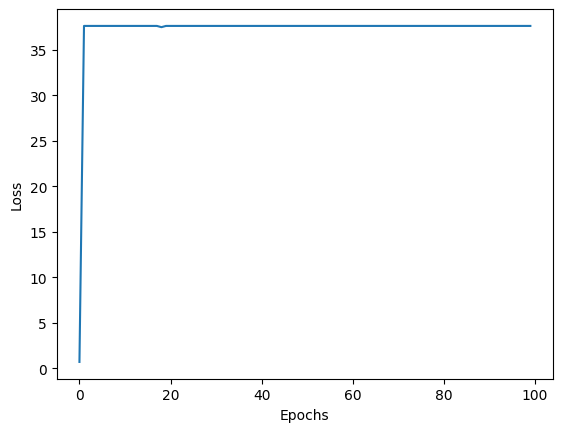

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [ ]:
corret = 0

with torch.no_grad():
  for i,data in enumerate(X):
    # Convert data to a PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    y_val = model.forward(data_tensor)

    # The print statement was incorrectly indented. Corrected indentation below:
    print(f'{i + 1}.) {str(y_val)} \t {data} \t {y_val.argmax().item() == y[i]}')

    if y_val.argmax().item() == y[i] :
      corret += 1

print(f'we goat {corret} correct out of ',len(y))

1.) tensor([0.]) 	 [ 0.82737724 -0.56573646  0.43279337 -0.47367361 -0.50244517] 	 True
2.) tensor([0.]) 	 [-1.56610693  0.66386103  0.43279337 -0.47367361  0.78684529] 	 False
3.) tensor([0.]) 	 [ 0.82737724 -0.25833709 -0.4745452  -0.47367361 -0.48885426] 	 False
4.) tensor([0.]) 	 [-1.56610693  0.4333115   0.43279337 -0.47367361  0.42073024] 	 False
5.) tensor([0.]) 	 [ 0.82737724  0.4333115  -0.4745452  -0.47367361 -0.48633742] 	 True
6.) tensor([0.]) 	 [ 0.82737724 -0.1046374  -0.4745452  -0.47367361 -0.47811643] 	 True
7.) tensor([0.]) 	 [-1.56610693  1.89345853 -0.4745452  -0.47367361  0.39581356] 	 True
8.) tensor([0.]) 	 [ 0.82737724 -2.10273333  2.24747049  0.76762988 -0.22408312] 	 True
9.) tensor([0.]) 	 [ 0.82737724 -0.18148724 -0.4745452   2.00893337 -0.42425614] 	 False
10.) tensor([0.]) 	 [-0.36936484 -1.18053521  0.43279337 -0.47367361 -0.0429555 ] 	 False
11.) tensor([0.]) 	 [ 0.82737724 -1.94903364  0.43279337  0.76762988 -0.31217238] 	 False
12.) tensor([0.]) 	 [-1.

In [ ]:
submission_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': test_predictions})
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
